In [1]:
# Importation 
import numpy as np
import base64
import struct
from cobs import cobs
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.signal
from scipy.io import savemat
import rawpy
import os
import pickle
from collections import namedtuple


from ScanImageTiffReader import  ScanImageTiffReader

In [197]:
def read_ScanImageTiffHeader(file_path):

    '''
    Reads header description information of ScanImageTiff File
    input: (str) tiff file path
    output: (list) Dictionary and list containing I2C events information and frame timestamps 
    
    '''
    frameTs = []
    i2c_timestamp = []
    i2c_values = []
    i2c_frameN = []

    with ScanImageTiffReader(file_path) as reader:
        time = reader.shape()[0]
        for frame in range(time):
            x = reader.description(frame)
            description = x.split('\n')
            frameTs.append(float(description[3].split('=')[1]))
            i2c= description[14].split('=')
            if len(i2c[1])>3:
                y = i2c[1].split('{{')[1].split(']}')
                if len(y)==1:
                    i2c_timestamp.append(float(y[events].split(',')[0]))
                    i2c_values.append(int(y[events].split('[')[1]))
                    i2c_frameN.append(frame)
                else: 
                    i2c_timestamp.append(float(y[0].split(',')[0]))
                    i2c_values.append(int(y[0].split('[')[1].split(',')[0]))
                    i2c_frameN.append(frame)
                    for events in range(1,len(y)-1):
                        i2c_timestamp.append(float(y[events].split(',')[0].split('{')[1]))
                        i2c_values.append(int(y[events].split('[')[1].split(',')[0]))
                        i2c_frameN.append(frame)
                        
    I2C = {"ts":i2c_timestamp, "val":i2c_values, "frameNum":i2c_frameN}
    return I2C, frameTs


def unpack_data_packet(dp,DataPacketStruct,DataPacket):
    s = struct.unpack(DataPacketStruct, dp)
    up = DataPacket(type=s[0], size=s[1], crc16=s[2], packetID=s[3], us_start=s[4], us_end=s[5],
                    analog=s[6:14], states=s[14:22], digitalIn=s[22], digitalOut=s[23], padding=None)
    return up

def count_lines(fp):
    # function to count the packet number
    def _make_gen(reader):
        b = reader(2**16)
        while b:
            yield b
            b = reader(2**16)
    with open(fp, 'rb') as f:
        count = sum(buf.count(b'\n') for buf in _make_gen(f.raw.read))
    return count


def create_bp_structure(bp):
    # Format package
    DataPacketDesc = {'type': 'B',
                      'size': 'B',
                      'crc16': 'H',
                      'packetID': 'I',
                      'us_start': 'I',
                      'us_end': 'I',
                      'analog': '8H',
                      'states': '8l',
                      'digitalIn': 'H',
                      'digitalOut': 'B',
                      'padding': 'x'}

    DataPacket = namedtuple('DataPacket', DataPacketDesc.keys())
    DataPacketStruct = '<' + ''.join(DataPacketDesc.values())
    DataPacketSize = struct.calcsize(DataPacketStruct)

    # package with non-digital data
    dtype_no_digital = [
        ('type', np.uint8),
        ('size', np.uint8),
        ('crc16', np.uint16),
        ('packetID', np.uint32),
        ('us_start', np.uint32),
        ('us_end', np.uint32),
        ('analog', np.uint16, (8, )),
        ('states', np.uint32, (8, ))]

    # DigitalIn and DigitalOut
    dtype_w_digital = dtype_no_digital + [('digital_in', np.uint16, (16, )), ('digital_out', np.uint8, (8, ))]

    # Creating array with all the data (differenciation digital/non digital)
    np_DataPacketType_noDigital = np.dtype(dtype_no_digital)
    np_DataPacketType_withDigital = np.dtype(dtype_w_digital)
    # Unpack the data as done on the teensy commander code
    num_lines = count_lines(bp)
    log_duration = num_lines/1000/60

    # Decode and create new dataset
    data = np.zeros(num_lines, dtype=np_DataPacketType_withDigital)
    non_digital_names = list(np_DataPacketType_noDigital.names)

    with open(bp, 'rb') as bf:
        for nline, line in enumerate(tqdm(bf, total=num_lines)):
            bl = cobs.decode(base64.b64decode(line[:-1])[:-1])
            dp = unpack_data_packet(bl,DataPacketStruct,DataPacket)

            data[non_digital_names][nline] = np.frombuffer(bl[:-4], dtype=np_DataPacketType_noDigital)
            digital_arr = np.frombuffer(bl[-4:], dtype=np.uint8)
            data[nline]['digital_in'] = np.hstack([np.unpackbits(digital_arr[1]), np.unpackbits(digital_arr[0])])
            data[nline]['digital_out'] = np.unpackbits(np.array(digital_arr[2], dtype=np.uint8))
        #Check for packetID jumps
    jumps = np.unique(np.diff(data['packetID']))
    decoded = {"analog":data['analog'], "digitalIn":data['digital_in'], "digitalOut":data['digital_out'], "startTs":data['us_start'], "transmitTS":data['us_end'], "longVar":data['states'], "packetNums":data['packetID']}

    return decoded

In [199]:
# ### Define scan image path
scan_image_path = '/home/melisamc/Documentos/acc_2p_analysis/data/'
scan_file = '20220308_Nike_audseq_00001.tif'
### Define log file path
log_file_path = '/home/melisamc/Documentos/acc_2p_analysis/logfiles/'
log_file = '20220308-163155_225.b64'
### get IC2 events
[I2C, frameTs] = read_ScanImageTiffHeader(scan_image_path + scan_file)
frameTs = np.array(frameTs)
print('Number of frames:', frameTs.shape)
print('Mean Scanner time per frame:', np.mean(np.diff(frameTs)))
### get decoded log file information
decoded = create_bp_structure(log_file_path + log_file)

Number of frames: (22986,)
Mean Scanner time per frame: 0.03339563007004569


  0%|          | 0/791952 [00:00<?, ?it/s]

In [4]:
log_file_path_dec = '/home/melisamc/Documentos/acc_2p_analysis/logfiles_decoded/'
savemat(log_file_path_dec + '20221201-102828_264.mat', decoded)

In [5]:
packet = decoded

def read_digitals(digitalIn,labels):
    nChan = digitalIn.shape[1]
    onset = []
    offset = []

    for chan in range(nChan):
        diffChan = np.diff(digitalIn[:,chan])
        onset.append(np.where(diffChan==1)[0]+1)
        offset.append(np.where(diffChan==-1)[0])

    digIn = {'onset':onset,'offset':offset,'labels':labels}
    return digIn

def polarity_index(digIn):
    #### We need to check polarity, we can change the method later
    nChan = len(digIn['onset'])
    pol_index = np.zeros((nChan,))
    
    for n in range(nChan):
        nOn = len(digIn['onset'][n])
        nOff = len(digIn['offset'][n])
        nevents = min(nOn,nOff)
        
        if nevents !=0:
            medianFor = np.median(digIn['offset'][n][0:nevents]-digIn['onset'][n][0:nevents])
            medianBack = np.median(digIn['onset'][n][1:nevents]-digIn['offset'][n][0:nevents-1])
            if medianBack < medianFor:
                pol_index[n] = 1
                
    force_pol_index = np.ones((nChan,))
    force_pol_index[2]= 0
    force_pol_index[3]= 0
    force_pol_index[6]= 0
    force_pol_index[7]= 0
    pol_index = pol_index * force_pol_index

    return pol_index

def change_polarity(digIn,polarity):
    
    new_digIn_onset = []
    new_digIn_offset = []
    nChan = len(digIn['onset'])
    for n in range(nChan):
        if polarity[n] == 1:
            new_digIn_onset.append(digIn['offset'][n])
            new_digIn_offset.append(digIn['onset'][n])
        else:
            new_digIn_onset.append(digIn['onset'][n])
            new_digIn_offset.append(digIn['offset'][n])

    digIn['onset'] = new_digIn_onset
    digIn['offset'] = new_digIn_offset
    
    return digIn

In [6]:
digitalIn = packet['digitalIn'].astype(int)
digitalIn = np.flip(digitalIn,axis =1)
digitalOut = packet['digitalOut'].astype(int)
digitalOut = np.flip(digitalOut,axis =1)

###Pay attention because labels will change, this is under development
### Read digital In and Out
labelsIn = ['empty','empty','wheelA','wheelB','wheelC','IR_camera','scanner',
             'sound','???','reward_zone','environment1','environment2','environment3_broken',
             'tunnel1','tunnel2','environment3']
labelsOut = ['valve','empty','IR_LED_sync','empty','barcode','IR_LED','lick','empty']
digIn = read_digitals(digitalIn, labelsIn)
digOut = read_digitals(digitalOut,labelsOut)

### Check channel polarity (inverted or non inverted channels)
polarity = polarity_index(digIn)

In [7]:
### Trials definition
# A trial will be define as one if there is a reward zone onset in between

# Check first onset to be correct, that means being before the first offset
# Define environment 1 start times in env1St
first_onset = digIn['onset'][10][0]
first_offset = digIn['offset'][10][0]

digIn = change_polarity(digIn,polarity)

first_onset = digIn['onset'][10][0]
first_offset = digIn['offset'][10][0]

if first_onset > first_offset:
    env1St = np.zeros((len(digIn['onset'][10])+1,)).astype(int)
    env1St[0] = 1
    env1St[1:]= digIn['onset'][10]
else:
    env1St = digIn['onset'][10]
    
env2St = digIn['onset'][11]    
env3St = digIn['onset'][15]   

In [8]:
digIn['onset'][10][0]

23166

In [9]:
### sort events and id events
n_events = len(env1St) + len(env2St) + len(env3St)
events_id = np.zeros((n_events,))
events_time = np.zeros((n_events,))
events_id[0:len(env1St)] = 1
events_time[0:len(env1St)] = env1St
events_id[len(env1St):len(env1St) + len(env2St)] = 2
events_time[len(env1St):len(env1St) + len(env2St)] = env2St
events_id[len(env1St) + len(env2St):] = 3
events_time[len(env1St) + len(env2St):] = env3St
sorted_index = np.argsort(events_time)
sorted_events_id = events_id[sorted_index].astype(int)
sorted_events_time = events_time[sorted_index]

In [61]:
#### make sure that there is a reward zone between all trial start
rewZonSt = digIn['onset'][9]
bins_edge = np.zeros((n_events+1,))
bins_edge[:-1] = sorted_events_time
bins_edge[-1] = np.max(sorted_events_time)+100000
env_with_RewZone = np.where(np.histogram(rewZonSt,bins_edge)[0])[0]

###redefine trial onset, Id and number of trials
trialOn = bins_edge[env_with_RewZone][0:11].astype(int)
trialId = sorted_events_id[env_with_RewZone][0:11].astype(int)
nTrials = 11#len(trialSt)

In [62]:
trialOn

array([  23166,   67044,  293577,  507349,  549415,  607919,  848080,
        943346, 1057283, 1094172, 1134334])

In [94]:
### Now we construct the trial info matrix
# % 1 env onset
# % 2 env id
# % 3 sound onset
# % 4 sound offset
# % 5 tunnel1 onset
# % 6 rewZone onset
# % 7 reward delivery
# % 8 tunnel2 onset
# % 9 tunnel2 offset
# % 10 trial duration

trialInfoLables = []

InfoEntrySize = 10
### Environment Start
trialInfo = np.zeros((nTrials,InfoEntrySize))
trialInfo[:,0] = trialOn[0:nTrials]
trialInfoLables.append('environmentStart')
### Environment ID
trialInfo[:,1] = trialId[0:nTrials]
trialInfoLables.append('environmentId')

### Tunnel 1 Onset 
tun1St = digIn['onset'][13][0:nTrials]
bins_edge = np.zeros((nTrials+1,))
bins_edge[:-1] = trialOn
bins_edge[-1] = np.max(trialOn)+100000
tun1St = tun1St[np.where(tun1St > bins_edge[0])]
[n_tun_in_trial,new_bins] = np.histogram(tun1St,bins_edge)
tun1St_ = np.zeros((nTrials,))
tun1St_[np.where(n_tun_in_trial)[0]] = tun1St
index_with_tunnel = np.where(n_tun_in_trial > 0)
index_with_one_tunnel = np.unique(index_with_tunnel)
trialInfo[index_with_one_tunnel,4] = tun1St_[index_with_one_tunnel] 
trialInfoLables.append('tunnel1Start')

### Sound Onset
SoundOnset = digIn['onset'][7][0:7]
temp = np.sort(trialInfo[:,[0,4]].flatten())
bins_edge = np.zeros((len(temp)+1,))
bins_edge[:-1] = temp
bins_edge[-1] = temp[-1] + 10000000000
[n_sounds_in_trial,new_bins] = np.histogram(SoundOnset,bins_edge)
trial_with_sound = (np.where(n_sounds_in_trial)[0]/2).astype(int)
#trial_with_sound_index = np.where(n_sounds_in_trial)[0]
trialInfo[trial_with_sound,2] = SoundOnset
trialInfoLables.append('SoundOnset')

### Sound Offset
SoundOffset = digIn['offset'][7][0:7]
temp = np.sort(trialInfo[:,[0,4]].flatten())
bins_edge = np.zeros((len(temp)+1,))
bins_edge[:-1] = temp
bins_edge[-1] = temp[-1] + 10000000000
[n_sounds_in_trial,new_bins] = np.histogram(SoundOffset,bins_edge)
trial_with_sound = (np.where(n_sounds_in_trial)[0]/2).astype(int)
#trial_with_sound_index = np.where(n_sounds_in_trial)[0]
trialInfo[trial_with_sound,3] = SoundOffset
trialInfoLables.append('SoundOffset')

### RewardZone1
rewZSt = digIn['onset'][9][0:nTrials]
bins_edge = np.zeros((nTrials+1,))
bins_edge[:-1] = trialOn
bins_edge[-1] = np.max(trialOn)+100000
rewZSt = rewZSt[np.where(rewZSt > bins_edge[0])]
[n_tun_in_trial,new_bins] = np.histogram(rewZSt,bins_edge)
rewZSt_ = np.zeros((nTrials,))
rewZSt_[np.where(n_tun_in_trial)[0]] = rewZSt
index_with_tunnel = np.where(n_tun_in_trial > 0)
index_with_one_tunnel = np.unique(index_with_tunnel)
trialInfo[index_with_one_tunnel,5] = rewZSt_[index_with_one_tunnel] 
trialInfoLables.append('RewardZoneStart')

### Tunnel 2 Onset 
tun2St = digIn['onset'][13][0:nTrials]
bins_edge = np.zeros((nTrials+1,))
bins_edge[:-1] = trialOn
bins_edge[-1] = np.max(trialOn)+100000
tun2St = tun2St[np.where(tun2St > bins_edge[0])]
[n_tun_in_trial,new_bins] = np.histogram(tun2St,bins_edge)
tun2St_ = np.zeros((nTrials,))
tun2St_[np.where(n_tun_in_trial)[0]] = tun1St
index_with_tunnel = np.where(n_tun_in_trial > 0)
index_with_one_tunnel = np.unique(index_with_tunnel)
trialInfo[index_with_one_tunnel,7] = tun2St_[index_with_one_tunnel] 
trialInfoLables.append('tunnel2Start')

### Tunnel 2 Offset 
tun2Off = digIn['offset'][13][0:nTrials]
bins_edge = np.zeros((nTrials+1,))
bins_edge[:-1] = trialInfo[:,7]
bins_edge[-1] = np.max(trialInfo[:,7])+100000
tun2Off = tun2Off[np.where(tun2Off > bins_edge[0])]
[n_tun_in_trial,new_bins] = np.histogram(tun2Off,bins_edge)
tun2Off_ = np.zeros((nTrials,))
tun2Off_[np.where(n_tun_in_trial)[0]] = tun2Off
index_with_tunnel = np.where(n_tun_in_trial > 0)
index_with_one_tunnel = np.unique(index_with_tunnel)
trialInfo[index_with_one_tunnel,8] = tun2St_[index_with_one_tunnel] 
trialInfoLables.append('tunnel2End')

### Reward delivery (1srt)
rewDel = digOut['onset'][0][0:nTrials]
temp = np.sort(trialInfo[:,[5,7]].flatten())
bins_edge = np.zeros((len(temp)+1,))
bins_edge[:-1] = temp
bins_edge[-1] = temp[-1] + 10000000000
[n_rew_in_trial,new_bins] = np.histogram(rewDel,bins_edge)
trial_with_rew = (np.where(n_rew_in_trial)[0]/2).astype(int)
rewDel_ = np.zeros((nTrials,))
rewDel_[trial_with_rew] = rewDel[trial_with_rew]
index_with_rew = np.where(n_rew_in_trial > 0)
index_with_one_rew = np.unique(index_with_rew)
trialInfo[trial_with_rew,6] = rewDel[trial_with_rew]

trialInfoLables.append('rewardDelivery')
trialInfo[:,9] = trialInfo[:,8] - trialInfo[:,0]
trialInfoLables.append('trialDuration')

In [96]:
#### Now syncronize and we convert to frames
rawTs = packet['startTS']
firstPacket = rawTs[0] #- 1000 #(Jeroen's discussion, do we want zero or 1)
trialInfoTs = trialInfo.copy()
convert_channels = [0,2,3,4,5,6,7,8]
for n in convert_channels:
    trialInfoTs[:,n] = rawTs[trialInfo[:,n].astype(int)]/1000
trialInfoTs[:,9] = trialInfoTs[:,8] - trialInfoTs[:,0]


In [116]:
digOut['labels']

['valve',
 'empty',
 'IR_LED_sync',
 'empty',
 'barcode',
 'IR_LED',
 'lick',
 'empty']

In [168]:
logOnset = digOut['onset'][4]
logOnsetTs = rawTs[logOnset]/10**6 ### in seconds
difflogOnsetTs = np.diff(logOnsetTs)

scanOnset = np.array(I2C['val']) 
scanOnsetIndex = np.where(scanOnset == 1)[0]
scanTs = np.array(I2C['ts'])
scanOnsetTs =scanTs[scanOnsetIndex]
diffscanOnsetTs = np.diff(scanOnsetTs)

767.673804935


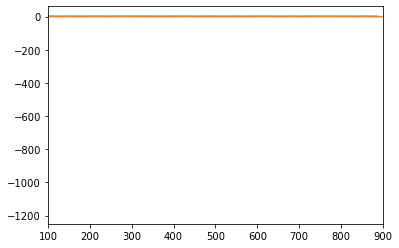

In [195]:
figure, axes = plt.subplots()
axes.plot(difflogOnsetTs)
axes.plot(diffscanOnsetTs)
axes.set_xlim([100,900])

print(scanOnsetTs[-1] - scanOnsetTs[0])

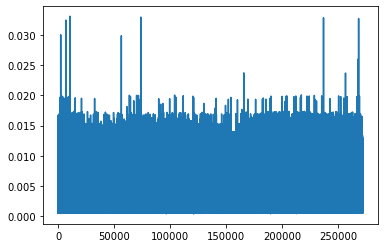

In [194]:
figure, axes = plt.subplots()
axes.plot(diffscanOnsetTs)


In [182]:
### compute offset assuming scanner time starts in 0
x = decoded['digitalIn'][:,0]
print(x[1])
x_diff = np.diff(x)
positions = np.where(x_diff == 1)[0]+1
what_we_want = x_diff[positions]

sampling_rate_scanner = np.mean(np.diff(positions))
offset_frames = round(positions[0]*sampling_rate_scanner/1000)

print('Offset is: ' + f'{positions[0]}' + ' ms ' )
print('Offset is: ' + f'{offset_frames}' + ' frames ')

print('Number of frames is: ', len(what_we_want))
print('Instantaneous Sampling rate is: ', sampling_rate_scanner)

0
Offset is: 293577 ms 
Offset is: 60512678 frames 
Number of frames is:  6
Instantaneous Sampling rate is:  206122.0
